# AutoKeras Analyzer API example

This notebook demonstrates the features of an Analyzer for [AutoKeras](https://www.autokeras.com/) network architecture search. Most of the code is outside the notebook, in a module [ak_utils.py](https://github.com/ceesroele/ak_searchspace/blob/main/ak_utils.py).

The issue the Analyzer seeks to address is:
* AutoKeras not delivering a report on the models it has probed. It effectively acts as a black box, just returning a "best model".
* Third-party tools like [TensorBoard](https://www.tensorflow.org/tensorboard) and [TRAINS](https://github.com/allegroai/trains) being weak on the kind of aggregation helpful when training lots of models having different architecture types.

While the latter tools effectively monitor the generate-and-evaluate process of AutoKeras, the current Analyzer acts only after the process is completed. It has some functions to report on the files the AutoKeras generates and also generates a DataFrame that can be used for further analysis.

## Imports

In [1]:
from IPython.core.display import HTML, display
from ak_utils import Analyzer
import ak_utils

## Analyzer class

Let's see what methods the `Analyzer` class makes available:

In [2]:
help(Analyzer)

Help on class Analyzer in module ak_utils:

class Analyzer(builtins.object)
 |  Analyzer(project_name=None, dir='.')
 |  
 |  Display results in Jupyter notebook
 |  
 |  Methods defined here:
 |  
 |  __init__(self, project_name=None, dir='.')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  dataframe_trials(self, metric='val_accuracy', with_reference=False)
 |      DataFrame with trial data
 |  
 |  display_search_space(self, architecture_type=None)
 |      Display overview of hyperparameters and their possible and default values.
 |      
 |      Arguments:
 |        architecture_type: if set, include only hyperparameters for this architecture type (`block_type`)
 |  
 |  plot_best_step(self, architecture_type=None)
 |      Display histogram with best step, that is, the epoch at which the highest accuracy was reached.
 |  
 |  plot_compare_architecture_types(self)
 |      Display comparison of architectures with regards to search space and project
 |  

## Initialization

We initialize the `Analyzer` with:
* `project_name` - same as used for AutoKeras, defining the directory under which trial data is stored
* `dir` - directory in which to locate `project_name`. If not set, `.` will be used. Allows you to run Jupyter in one directory and AutoKeras in another.

The `project_name` values I use here refer to AutoKeras runs I have done myself. Here If you want to run this notebook, download it and define the `program_name` settings for your own projects!

(If you are puzzled by the `_greedy` postfix for the project_name, I experimented with using different [Keras tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/) and here used the standard for AutoKeras `greedy` tuner.)

In [3]:
aview = Analyzer(project_name='text_classifier_greedy', dir='.')

And see a summary of the data it has found:

In [4]:
aview.summary()

"3 architecture types: ['vanilla', 'transformer', 'bert'], 4 trials, 3 epochs"

How should we read this?

1. The search space for models included three types of architectures:
   * `vanilla` - standard approach, LSTM for language
   * `transformer` - "new" transformer based architecture
   * `bert` - pre-configured and pre-trained models, "transfer learning"
2. Four trials have been done, that is, four models have been generated and evaluated (only four, because this was really a test)
3. These models have been trained for three epochs.

## Mapping the search space

Out of sight and control of the user, AutoKeras spans up a search space of "blocks" and "hyperparameters".
AutoKeras traverses the search space of possible architectures by changing at least one hyperparameter and then generating and testing a new model.

We can find the information on the search space ourselves by browsing the file `oracle.json`. Set the correct `program_name` yourself.

```bash
cat ${program_name}/oracle.json | python -m json.tool | less
```

Below you see a presentation of that data, but restricted to the architecture typ of `transformer`. 
Hyperparameters affecting models can be separated in those that are specific for the architecture, e.g. 
type of `pretraining` for the transformer architecture, and those that affect all architectures, which I call here `generic`.

Behind the hyperparameters you see a list of their possible values and in red the default value. 

In [5]:
aview.display_search_space(architecture_type='transformer')

## Search space per architecture

We have seen that:
* There are different architectures
* The hyperparameters that span up the search space vary per architecture

Ignoring some dependencies, we can now see that our AutoKeras search space consists for the most part
of options for the `vanilla` architecture.

However, given that there are also 'generic' hyperparameters like `learning_rate`, which are applicable to all architecture types, the total number of parameters that can be changed for any model is higher.

Below:
* Hyperparameters per architecture type
* Hyperparameters for architecture type and generic combined
* Number of trials done per architecture type

Looking at the resulting graphs can give us an impression of the AutoKeras search space and the part of it that AutoKeras actually traverses.

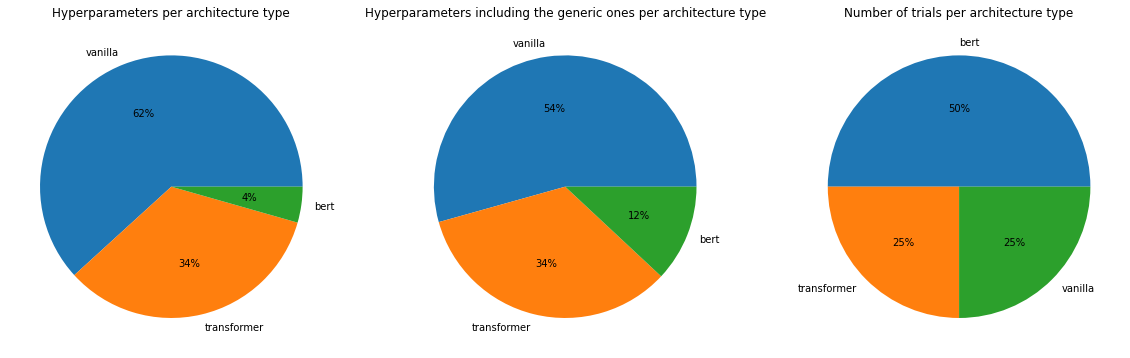

In [6]:
aview.plot_compare_architecture_types()

Let's see what hyperparameters are available for one architecture type:

In [18]:
aview.display_search_space(architecture_type='bert')

We see that there are only six possible parameter values specific to `bert` and belonging to two variables.
`dropout`, `optimizer`, and `learning_rate` can still be changed.

## Trials

Now, let's look at actual trials. 

We can find trial data under the `${dir}/${project_name}/trial_xyz` directories.

Hyperparameter settings and data on metrics are in `trial.json`, which we can read with:

```bash
cat ${program_name}/trial_xyz/trial.json | python -m json.tool | less
```

With the following call we get all hyperparameter settings and all
results per epoch for all trials.

In [8]:
df = aview.dataframe_trials()
df.head()

,text_block_1/block_type,classification_head_1/dropout,optimizer,learning_rate,text_block_1/max_tokens,text_block_1/bert_block_1/max_seq_len,block_type,trial_id,best_step,max_val_accuracy,...,text_block_1/spatial_reduction_1/reduction_type,text_block_1/dense_block_1/num_layers,text_block_1/dense_block_1/use_batchnorm,text_block_1/dense_block_1/dropout,text_block_1/dense_block_1/units_0,text_block_1/transformer_1/pretraining,text_block_1/transformer_1/embedding_dim,text_block_1/transformer_1/num_heads,text_block_1/transformer_1/dense_dim,text_block_1/transformer_1/dropout
3,bert,0.0,adam_weight_decay,0.00002,20000,512.0,bert,856246e20a0d5a4875bd63e11ad38386,0,0.613095,...,None,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN
2,transformer,0.0,adam,0.00100,20000,NaN,transformer,94f894d991d5316766799d8ef7b52b26,2,0.523810,...,global_avg,1.0,False,0.5,20.0,none,32.0,2.0,32.0,0.25
1,vanilla,0.0,adam,0.00100,5000,NaN,vanilla,214214432b1631914237a17fe94b8f36,2,0.517857,...,global_max,1.0,False,0.5,256.0,None,NaN,NaN,NaN,NaN
0,bert,0.5,sgd,0.00010,5000,128.0,bert,3076596639421dc39a34495eda7b2dd5,2,0.434524,...,None,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaN


As there are too many columns to display in the DataFrame head, let's see what they are:

In [17]:
df.columns

Index(['image_block_1/normalize', 'image_block_1/augment',
       'image_block_1/block_type', 'image_block_1/res_net_block_1/pretrained',
       'image_block_1/res_net_block_1/version',
       'image_block_1/res_net_block_1/imagenet_size',
       'classification_head_1/spatial_reduction_1/reduction_type',
       'classification_head_1/dropout', 'optimizer', 'learning_rate',
       'block_type', 'trial_id', 'best_step', 'max_val_accuracy',
       'metric_direction', 'step_0', 'step_1', 'step_2', 'step_3', 'step_4',
       'step_5', 'step_6', 'step_7', 'step_8', 'step_9', 'step_10', 'step_11',
       'step_12', 'step_13', 'step_14', 'step_15', 'step_16', 'step_17',
       'step_18', 'step_19', 'step_20', 'step_21', 'step_22', 'step_23',
       'step_24', 'size', 'mtime', 'image_block_1/res_net_block_1/trainable',
       'image_block_1/image_augmentation_1/translation_factor',
       'image_block_1/image_augmentation_1/horizontal_flip',
       'image_block_1/image_augmentation_1/vertical_

In the DataFrame, trials are rows. The columns contain:
* the hyperparameter settings for the specific trial
* file-system meta-data specific for the trial: `mtime` of trial.json and `size` of a checkpoint
* `val_accuracy` of the steps of the trial

## Best trials

Rather than plot lines for all trials, let's focus on architecture types and display the val_accuracy per step for the best trials of every architecture.

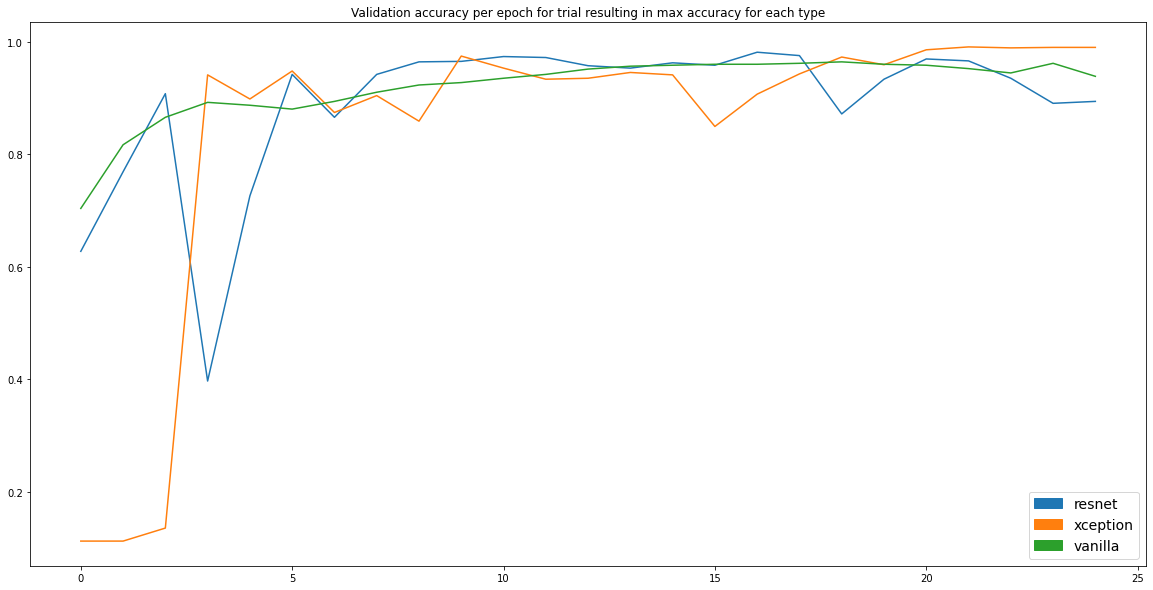

In [16]:
aview.plot_trial_run()

## For images: Architecture versions

When using a ResNet model a version is set. As the different ResNet versions are fundamentally different, we want to treat them as separate architectures.

Let's first redirect our analyzer to an AutoKeras run done by me on image classification.

In [10]:
aview = Analyzer(project_name='image_classifier_greedy', dir='.')

For this reason we create a new column `versioned_block_type` which in the case of ResNet contains the version and in all other cases the `block_type`.

In [11]:
def versioned_blocktype(row):
    """If a block_type has a (resnet) version, return the version, otherwise the block_type"""
    versioned = row['block_type']
    if 'image_block_1/res_net_block_1/version' in row.keys() and row['image_block_1/res_net_block_1/version']:
        versioned = row['image_block_1/res_net_block_1/version']
    return versioned

df = aview.dataframe_trials()
if 'image_block_1/res_net_block_1/version' in df.columns:
    df['versioned_block_type'] = df.apply(lambda x: versioned_blocktype(x), axis=1)
    display(df[['size', 'max_val_accuracy', 'versioned_block_type']])

,size,max_val_accuracy,versioned_block_type
15,250244517,0.990582,xception
28,250247885,0.988870,xception
17,250244992,0.987158,xception
41,250244517,0.986301,xception
33,262040997,0.985445,xception
13,250244517,0.984589,xception
39,262041014,0.983733,xception
43,262040997,0.982877,xception
14,250244517,0.982877,xception
31,250244517,0.982021,xception


## Plot trials over time

Have you ever wondered in what sequence AutoKeras generated its models to be tested? Let's see!

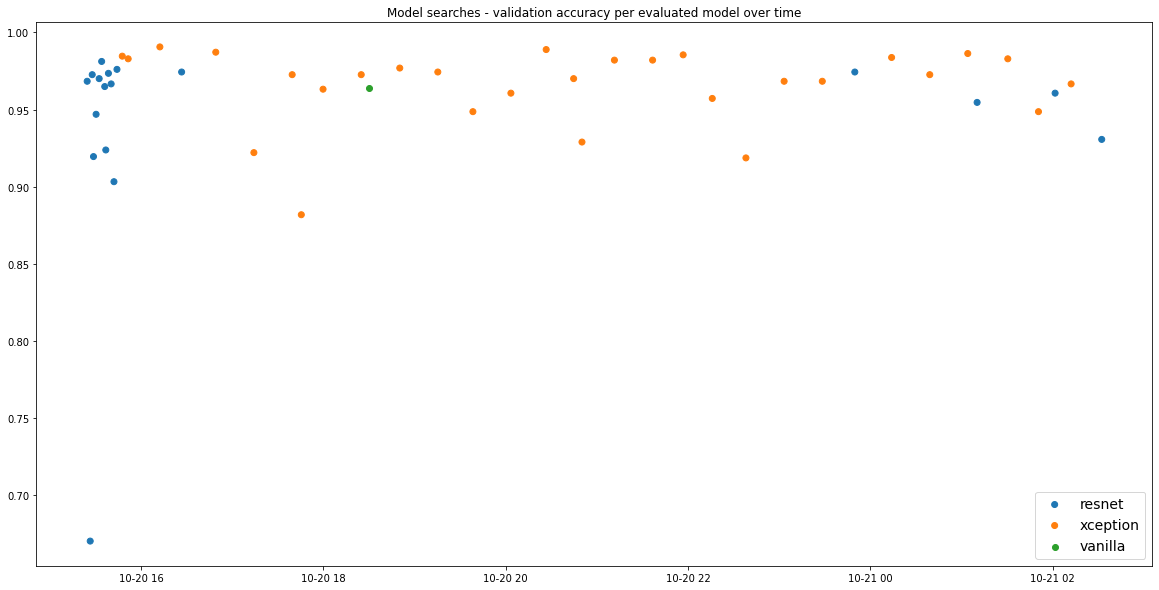

In [12]:
aview.plot_trials_over_time()

## Epochs and result

Can we tell if our selected number of epochs was reasonable? We can just created a histogram for during what epoch the best accuracy was achieved during a trial.

If the highests counts are at the beginning or in the middle, additional training epochs don't seem to have a positive effect. But if the highest counts are at or near the end of the epochs, then it is likely that longer training leads to better results.

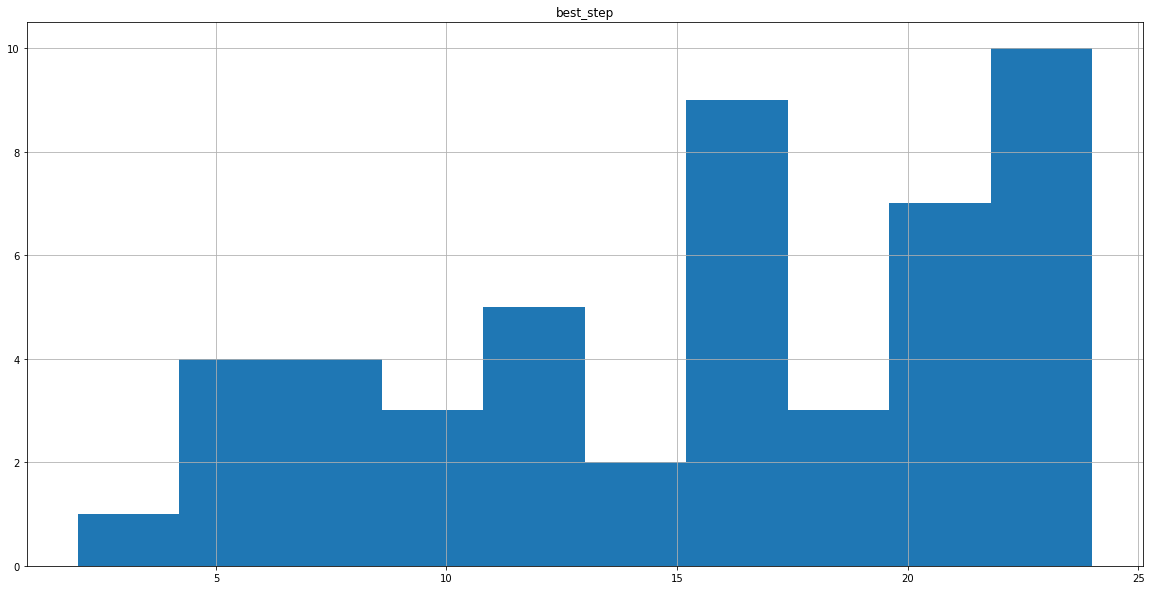

In [13]:
aview.plot_best_step()

## Trial progress

We can see the validation accuracy per epcoh for a trial by calling 

`aview.plot_trial_run(trial_id=[my trial id])`

Let's just take whatever happens to be the first read in trial.

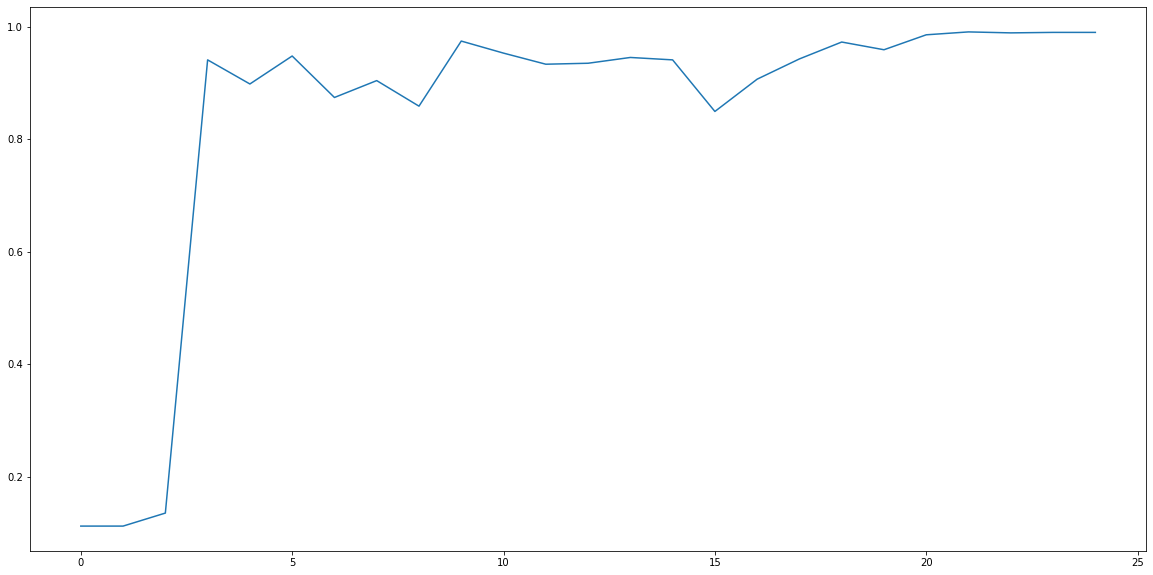

In [14]:
trial_id = list(aview.analyzer._trials.keys())[0] # just take the first of the read in trials
aview.plot_trial_run(trial_id=trial_id)

## Browse through trials

There are better tools available than this, but here we still have a possibility to see how the validation accuracy develops over periods. Just press &lt;Shift-Enter&gt; to see the next trial.

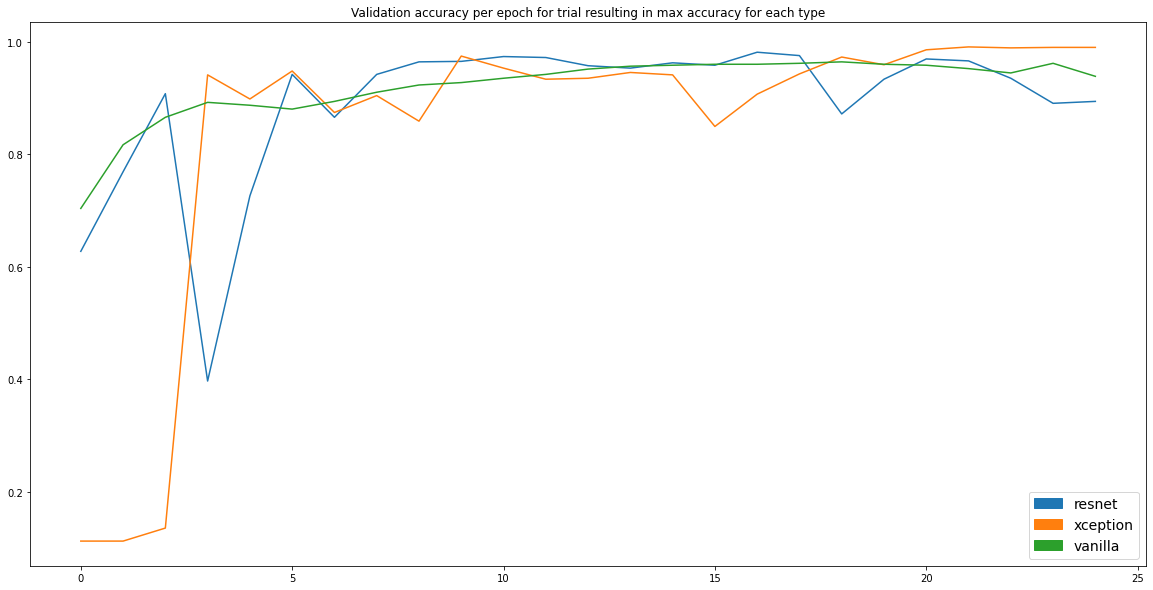

In [15]:
aview.plot_trial_run()

## Feedback

Any questions, comments, reports? Find me through [https://github.com/ceesroele](https://github.com/ceesroele) .